# Linear Regression: From Statistical Theory to Production Systems

This notebook demonstrates a deep, end-to-end understanding of linear regression covering:

- Statistical foundations  
- Numerical linear algebra  
- Optimization  
- Regularization  
- Diagnostics  
- Model selection  
- Production pipelines   

---

## Model

We assume the classical linear model:

$$
y = X\beta + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I)
$$

The Ordinary Least Squares estimator is:

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

However — computing the inverse directly is **not recommended** in practice due to numerical instability.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

np.random.seed(1)

# 1. Synthetic Data Generation

We generate data from a known parameter vector so that we can verify whether our estimators recover the true coefficients.

$$
y = X\beta + \varepsilon
$$

This approach is widely used in methodological research.


In [2]:
n = 300
p = 6

X = np.random.randn(n, p)

true_beta = np.array([3, -2, 0, 0, 1.5, -4])

noise = np.random.randn(n) * 0.7

y = X @ true_beta + noise

print("True beta:\n", true_beta)


True beta:
 [ 3.  -2.   0.   0.   1.5 -4. ]


# 2. OLS via Normal Equation

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

Direct inversion is:

- numerically unstable  
- computationally expensive $O(p^3)$  
- fails when $X^TX$ is singular  

We compute it only for conceptual clarity.


In [3]:
beta_normal = np.linalg.inv(X.T @ X) @ X.T @ y

print("Estimated beta:")
print(beta_normal)


Estimated beta:
[ 2.9997718  -2.08686128 -0.03938944 -0.09120504  1.56907687 -3.97728393]


## Insight

Why should you avoid inverting $X^TX$?

- Small eigenvalues explode during inversion  
- Leads to high estimator variance  
- Better alternatives exist: QR and SVD


# 3. Numerically Stable Solution Using SVD

Factorize:

$$
X = U\Sigma V^T
$$

Then,

$$
\hat{\beta} = V\Sigma^{-1}U^Ty
$$

SVD handles rank deficiency gracefully and is preferred in scientific computing libraries.


In [4]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)

beta_svd = Vt.T @ np.diag(1/S) @ U.T @ y

print(beta_svd)


[ 2.9997718  -2.08686128 -0.03938944 -0.09120504  1.56907687 -3.97728393]


# Geometric Interpretation

OLS is the orthogonal projection of $y$ onto the column space of $X$.

Understanding this geometry is a strong signal of mathematical maturity.


# 4. Optimization Perspective — How Gradient Descent Works

OLS can be written as the optimization problem:

$$
\min_\beta J(\beta) = ||y - X\beta||_2^2
$$

Expanding:

$$
J(\beta) = (y - X\beta)^T (y - X\beta)
$$

Taking the gradient:

$$
\nabla_\beta J = -2X^T(y - X\beta)
$$

---

## What Gradient Descent Does

We iteratively update the parameter vector:

$$
\beta_{t+1} = \beta_t - \eta \nabla_\beta J
$$

where:

- $\eta$ = learning rate (step size)
- $\nabla_\beta J$ = direction of steepest increase

Thus, **subtracting the gradient moves us toward the minimum**.

---

## What Happens in the Code

Each iteration:

1. Compute prediction: $X\beta$
2. Compute residual: $y - X\beta$
3. Compute gradient using $X^T(y-X\beta)$
4. Update $\beta$

When the loss stops decreasing, we are near the OLS solution.

**Important insight:**  
For linear regression, gradient descent converges to the same solution as the normal equation — but this optimization viewpoint generalizes to nearly all ML models.


In [7]:
beta = np.zeros(p)
lr = 0.01

losses = []

for _ in range(2000):
    gradient = -2 * X.T @ (y - X @ beta)
    beta -= lr * gradient / n
    
    loss = np.mean((y - X @ beta)**2)
    losses.append(loss)

print(beta)

[ 2.9997718  -2.08686128 -0.03938944 -0.09120504  1.56907687 -3.97728393]


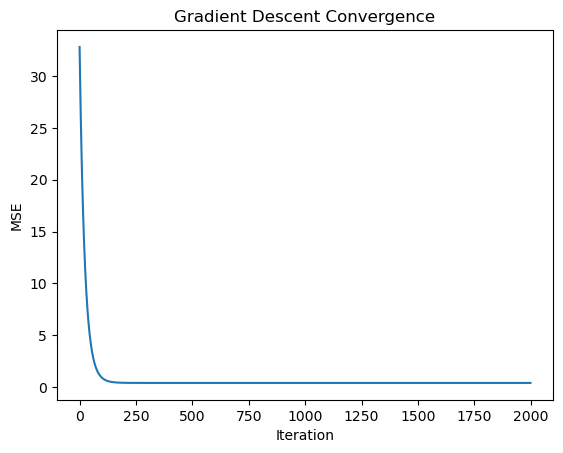

In [8]:
plt.plot(losses)
plt.title("Gradient Descent Convergence")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()


# 5. Conditioning and Multicollinearity

The condition number is:

$$
\kappa(X) = \frac{\sigma_{\max}}{\sigma_{\min}}
$$

where:

- $\sigma_{\max}$ = largest singular value of $X$  
- $\sigma_{\min}$ = smallest singular value  

These singular values come from the **Singular Value Decomposition (SVD)**:

$$
X = U \Sigma V^T
$$

Here, $\Sigma$ is a diagonal matrix containing the singular values.

---

## Interpretation

If $\sigma_{\min}$ is very small:

- $X$ is close to being rank deficient  
- Columns of $X$ are nearly linearly dependent  
- Small noise causes large swings in $\hat{\beta}$  

This is the mathematical origin of **multicollinearity**.


In [9]:
cond = np.linalg.cond(X)
print("Condition number:", cond)


Condition number: 1.2285205275855682


# 6. Ridge Regression

Ridge solves:

$$
\hat{\beta} = (X^TX + \lambda I)^{-1}X^Ty
$$

---

## Bayesian Interpretation

Ridge is equivalent to assuming a Gaussian prior:

$$
\beta \sim \mathcal{N}(0, \tau^2 I)
$$

where:

- $\tau^2$ is the prior variance  
- Smaller $\tau^2$ ⇒ stronger belief that coefficients should be near zero  

---

## Connection Between $\lambda$ and $\tau^2$

They are inversely related:

$$
\lambda = \frac{\sigma^2}{\tau^2}
$$

Meaning:

- Large $\lambda$ ⇒ small prior variance ⇒ stronger shrinkage.


In [10]:
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

print(ridge.coef_)


[ 2.99182625 -2.08000891 -0.03957785 -0.08894376  1.56919545 -3.96102682]


# 7. Lasso and Sparsity

Lasso solves:

$$
\min_\beta ||y-X\beta||^2 + \lambda ||\beta||_1
$$

---

## Why Does L1 Produce Exact Zeros?

Consider the constraint form:

$$
||\beta||_1 \leq t
$$

The geometry of this constraint is a **diamond-shaped region** with sharp corners.

The OLS loss has elliptical contours.  
When the ellipse first touches the constraint boundary, it often hits a corner.

At the corners:

$$
\beta_j = 0
$$

for some coefficients.

---

## Contrast with Ridge

Ridge uses the L2 norm:

$$
||\beta||_2^2
$$

which forms a sphere — smooth with no corners.

Therefore:

- Ridge shrinks coefficients.
- Lasso performs **automatic feature selection**.


In [11]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

print(lasso.coef_)


[ 2.90824398 -1.99187432 -0.         -0.          1.50213381 -3.87336319]


# 8. Bias–Variance Tradeoff Simulation

$$
\text{Test Error} = \text{Bias}^2 + \text{Variance} + \sigma^2
$$

We vary model complexity using polynomial regression.


c:\Users\Unnati Nigam\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.62441e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Unnati Nigam\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.07404e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Unnati Nigam\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.76107e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Unnati Nigam\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.84191e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


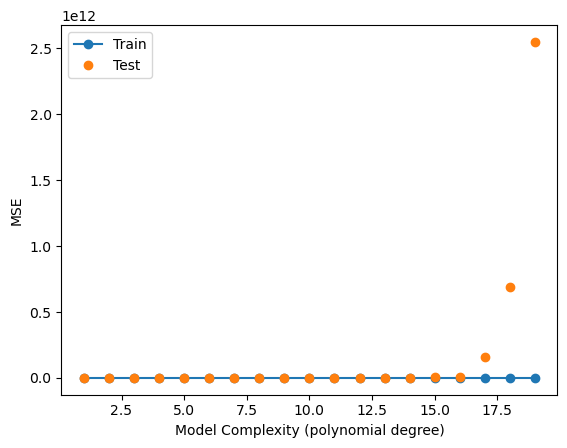

In [15]:
X1 = X[:,0].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.3, random_state=1
)

degrees = range(1, 20)

train_err = []
test_err = []

for d in degrees:
    
    model = Pipeline([
        ("poly", PolynomialFeatures(d)),
        ("ridge", Ridge(alpha=1e-3))
    ])
    
    model.fit(X_train, y_train)
    
    train_err.append(mean_squared_error(y_train, model.predict(X_train)))
    test_err.append(mean_squared_error(y_test, model.predict(X_test)))

plt.plot(degrees, train_err, 'o-',label="Train")
plt.plot(degrees, test_err,'o' ,label="Test")
plt.legend()
plt.xlabel("Model Complexity (polynomial degree)")
plt.ylabel("MSE")
plt.show()


# 9. Statistical Inference

Under Gaussian noise, OLS is the Maximum Likelihood Estimator.

We now examine:

- standard errors  
- t-statistics  
- p-values  
- confidence intervals  


In [16]:
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3945.
Date:                Mon, 02 Feb 2026   Prob (F-statistic):          6.54e-277
Time:                        01:44:10   Log-Likelihood:                -295.12
No. Observations:                 300   AIC:                             604.2
Df Residuals:                     293   BIC:                             630.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0355      0.038     -0.931      0.3

## Interpretation Tip 

If a coefficient is insignificant, possible causes include:

- multicollinearity  
- insufficient data  
- high noise  
- model misspecification  


# 10. Residual Diagnostics

We check whether:

$$
\mathbb{E}[\varepsilon | X] = 0
$$


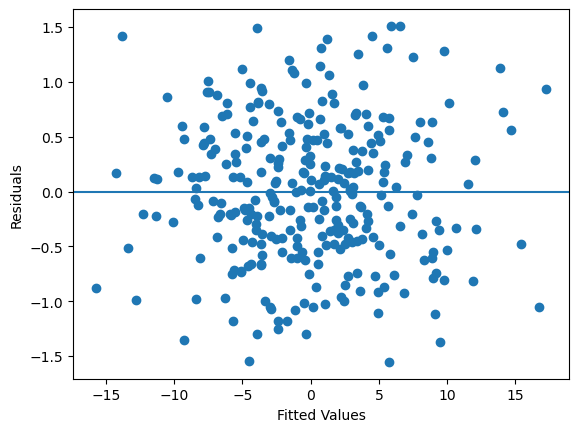

In [17]:
residuals = model.resid

plt.scatter(model.fittedvalues, residuals)
plt.axhline(0)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()


# 11. Cross Validation

We use **K-fold cross validation**.

Procedure:

1. Split data into $K$ equal folds.
2. Train on $K-1$ folds.
3. Validate on the remaining fold.
4. Repeat $K$ times.

$$
CV = \frac{1}{K} \sum_{k=1}^K L_k
$$

---

## What is $K$?

It is the number of splits.

Typical choices:

- $K=5$ → faster  
- $K=10$ → lower variance estimate  

Cross-validation estimates how well the model generalizes to unseen data.


In [18]:
scores = cross_val_score(
    Ridge(alpha=1.0),
    X,
    y,
    scoring="neg_mean_squared_error",
    cv=5
)

print("CV MSE:", -scores.mean())


CV MSE: 0.434278401897717


# 12. Production Pipeline

Key rule:

> Never scale data outside a pipeline — it causes data leakage.


In [20]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

pipeline.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

# Important

### Why does OLS fail when $p > n$?
Because $X^TX$ becomes singular.

---

### Ridge vs Lasso
- Ridge - shrinkage  
- Lasso - feature selection  

---

### Why Does Ridge Correspond to a Gaussian Prior?

Ridge minimizes:

$$
||y-X\beta||^2 + \lambda ||\beta||_2^2
$$

This is equivalent to maximizing the posterior:

$$
p(\beta | y) \propto p(y|\beta)p(\beta)
$$

with:

$$
\beta \sim \mathcal{N}(0,\tau^2 I)
$$

Thus, ridge is the **MAP estimator** under a Gaussian prior.

---

### Geometry
OLS is a projection onto the column space of $X$.

---

### When should you prefer SVD?
Whenever numerical stability matters.

---

### Bayesian View
Ridge corresponds to a Gaussian prior on coefficients.

---

# Closing Remark

Linear regression is not merely a baseline model — it is the foundation upon which much of modern statistical learning is built.
